<a href="https://www.kaggle.com/code/vincentvandeghinste/mtat26-chapter5-rnns?scriptVersionId=300045552" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Chapter 5 Hands-on RNNs

## 5.2 Scaling up: A Vanilla RNN NMT Baseline

The first neural machine translation systems were based on recurrent encoder–decoder architectures
without attention (Cho et al., 2014; Sutskever et al., 2014). In this section, we will experimentally
test how well such a system works for our data

In the previous section we implemented a minimal encoder–decoder model in Keras to understand
every step of training and inference. We now switch to the `rnn_seq2seq.py` training script, which
allows us to run controlled MT experiments on a larger dataset and to compare architectural
improvements in a reproducible way.

To ensure that all improvements in this chapter are comparable, we re-use the data preparation
and evaluation workflow introduced earlier:
* **Data preparation**. We use the same preprocessing pipeline and, crucially, a fixedcdevelopment and test set (Chapter 2). This avoids “moving targets”: if the dev set changes,BLEU changes even if the model does not.
* **Evaluation**. We will only do a final evaluation on the test set, once we’ve developed acsystem that works reasonably well on the test set, using overlap metrics and semantic metrics (Chapter 3): BLEU, chrF, BERTScore, and COMET.

The command-line options for the script are presented in the following table

| Option | Default | Comment |
|---|---:|---|
| `--mode` | `train` | Run the script in training mode |
| `--src-file` | – | Source language training file (required) |
| `--tgt-file` | – | Target language training file (required) |
| `--src-val` | – | Source validation file (optional) |
| `--tgt-val` | – | Target validation file (optional) |
| `--epochs` | 30 | Nr of training epochs |
| `--batch-size` | 32 | Nr of sentence pairs per batch |
| `--emb-size` | 64 | Size of word embeddings |
| `--hidden-size` | 128 | Size of the RNN hidden state |
| `--enc-layers` | 1 | Nr of encoder RNN layers |
| `--dec-layers` | 1 | Nr of decoder RNN layers |
| `--rnn-type` | `rnn` | Recurrent cell type (`rnn`, `gru`, `lstm`) |
| `--attention` | `none` | Attention mechanism (`none`, `luong`) |
| `--bidirectional` | false | Use a bidirectional encoder |
| `--dropout` | 0.0 | Dropout probability |
| `--teacher-forcing` | 0.7 | Teacher forcing ratio |
| `--lr` | 0.001 | Learning rate |
| `--max-len` | 20 | Maximum sentence length (tokens) |
| `--limit` | – | Limit nr of training sentence pairs (debugging) |
| `--max-src-vocab` | – | Max source vocabulary size |
| `--max-tgt-vocab` | – | Max target vocabulary size |
| `--lower` | false | Lowercase all text |
| `--subword-type` | `none` | Subwording (`none`, `bpe`, `unigram`) |
| `--src-sp-model` | – | Source SentencePiece model |
| `--tgt-sp-model` | – | Target SentencePiece model |
| `--save` | `model_att.pt` | Base filename for checkpoints |
| `--save-best` | – | Filename for best model (`*.best.pt`) |
| `--keep-last` | 1 | Keep last N epoch checkpoints |
| `--early-stopping` | 0 | Stop after N non-improving epochs (0 disables) |
| `--early-metric` | `loss` | Metric for early stopping / best model |
| `--eval-metrics` | false | Compute BLEU/chrF/TER on validation data |
| `--show-val-examples` | 0 | Nr of validation examples to print |
| `--save-val-json` | – | Save validation outputs as JSON |
| `--save-val-trans` | – | Save validation outputs as TSV |
| `--history-json` | – | Save training/validation history to JSON |
| `--seed` | 42 | Random seed |



### 5.2.1 Install necessary scripts

The first thing we need to do is to download the required scripts and modules to the Kaggle
session.
* `sacrebleu` for evaluation
* `rnn_seq2seq.py` script to train and translate
* `plot_train_val.py` script to compare training vs validation scores
* `plot_history.py` script to compare different approaches

In [1]:
!pip install sacrebleu
!wget https://raw.githubusercontent.com/VincentCCL/MTAT/refs/heads/main/code/rnn_seq2seq.py
!wget https://raw.githubusercontent.com/VincentCCL/MTAT/refs/heads/main/code/plot_train_val.py
!wget https://raw.githubusercontent.com/VincentCCL/MTAT/refs/heads/main/code/plot_history.py
from IPython.display import Image, display

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 3.6 MB/s eta 0:00:00
--2026-02-25 15:16:35--  https://raw.githubusercontent.com/VincentCCL/MTAT/refs/heads/main/code/rnn_seq2seq.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63710 (62K) [text/plain]
Saving to: ‘rnn_seq2seq.py’

rnn_seq2seq.py      100%[===================>]  62.22K  --.-KB/s    in 0.01s   

2026-02-25 15:16:36 (5.26 MB/s) - ‘rnn_seq2seq.py’ saved [63710/63710]

--2026-02-25 15:16:36--  https://raw.githubusercontent.com/VincentCCL/MTAT/refs/heads/main/code/plot_train_val.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:4

### 5.2.2 Goal of the Baseline
This first script-based experiment establishes a baseline system that mirrors early NMT: a plain
encoder–decoder architecture without attention, without gating (no GRU/LSTM), and without
subwording.

The point is not to obtain state-of-the-art quality, but to create a **reference point** against which
later improvements (GRU/LSTM, bidirectionality, attention, subwording) can be measured

### 5.2.3 Training the RNN Baseline

In [2]:
!python rnn_seq2seq.py --src-file /kaggle/input/tatoeba-en-nl/train.en --tgt-file /kaggle/input/tatoeba-en-nl/train.nl \
--src-val /kaggle/input/tatoeba-en-nl/dev.en --tgt-val /kaggle/input/tatoeba-en-nl/dev.nl \
--epochs 10 \
--save rnn_baseline.pt \
--show-val-examples 5 \
--eval-metrics \
--lower \
--history-json rnn.hist

Setting random seed to 42
Loaded 1000 validation sentence pairs.
Source vocab size: 15514
Target vocab size: 20997
[info] lower = True
Loaded 77381 training pairs. 76539 used after max_len=20 filtering. 
Total trainable parameters: 5,094,981
Epoch 01: train NLL=5.2905 (ppl=198.44)  val NLL=5.4864 (ppl=241.39)  BLEU=0.14  ChrF=7.66  TER=97.51

--- Example validation translations ---
[1] SRC: nobody reads about my country .
    REF: niemand leest over mijn land .
    HYP: is een van van de . . . .

[2] SRC: i sleep in my car .
    REF: ik slaap in mijn auto .
    HYP: is een van van . .

[3] SRC: there 're clean sheets under the bed .
    REF: er liggen schone lakens onder het bed .
    HYP: is een van van de van . . .

[4] SRC: i have a donkey .
    REF: ik heb een ezel .
    HYP: is een van van . .

[5] SRC: betty drives fast .
    REF: betty rijdt snel .
    HYP: is een van . .

---------------------------------------
Epoch 02: train NLL=4.8227 (ppl=124.30)  val NLL=5.3294 (ppl=206.31

While training, after each epoch, the script will translate the development set and calculate
different metrics on it.

We can already see from the example validation translations during training that results
are rather bad and unmeaningful. A question we can ask is whether the models are actually
learning something.

### 5.2.4 Plotting the Learning Curve

Neural MT should gradually improve over epochs. A learning curve makes this visible and helps
diagnose convergence and overfitting. The training script can write a JSON history file (e.g.
`rnn.hist`) containing per-epoch values.

We have provided two scripts that plots the values in these history files, which have been
downloaded in the initial step: `plot_train_val.py` and `plot_history.py`.

#### 5.2.4.1 Interpreting Training and Validation Loss 

The `plot_train_val.py` script generates a plot
that allows to compare the curves for training versus validation loss.

Saved plot to rnn.png


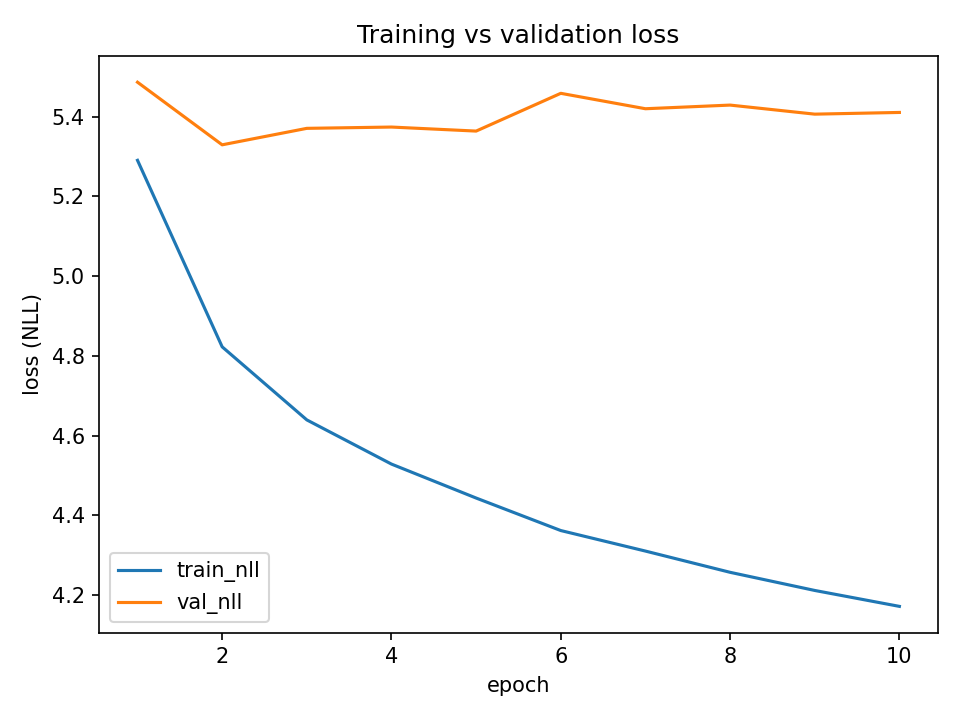

In [3]:
!python plot_train_val.py rnn.hist --save rnn.png
display(Image(filename="rnn.png"))

Comparing training and validation loss over epochs provides insight into how well a model
generalises beyond the data it was trained on.
* When both curves decrease together, the model is learning patterns that transfer to unseen
sentences.
* If training loss continues to decrease while validation loss stops improving or starts to
increase, the model begins to overfit: its performance on the training data improves, but its
performance on new data deteriorates.

The difference between the two curves, often called the *generalisation gap*, indicates how strongly
the model adapts to the training data. In neural machine translation, a growing gap may reflect
that the model increasingly captures properties specific to the training corpus, such as frequent
constructions or recurring sentence patterns, rather than learning more general translation
correspondences.

Training–validation comparisons are also useful for practical decisions. They help determine
whether training should be stopped earlier (early stopping) and whether increasing model
complexity is justified given the available data. For this reason, inspecting training and validation
loss is an essential step in analysing and comparing NMT experiments.

As we can see in the Figure we see a clear case of overfitting. We can see that the loss on the training data steadily decreases, but that this is absolutely not the case for the validation loss.

#### 5.2.4.2 Plotting the BLEU curve

This is confirmed by the BLEU score history, which can be visualised with

Saved plot to rnn_bleu.png


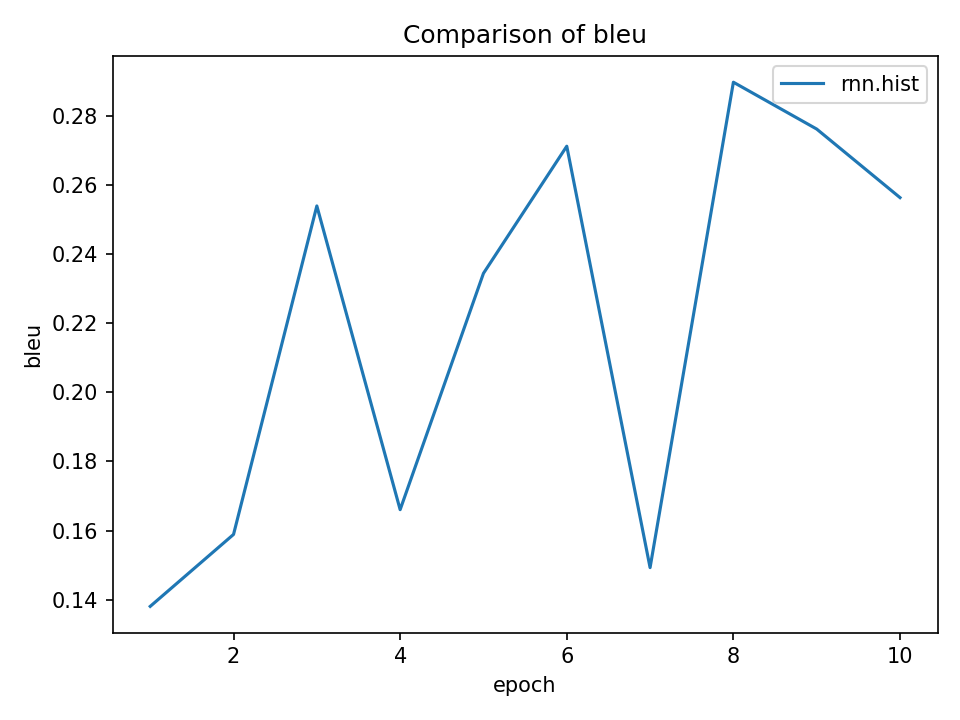

In [4]:
!python plot_history.py rnn.hist --metric bleu --save rnn_bleu.png
display(Image(filename="rnn_bleu.png"))

We see the BLEU score vary between 0.14 and 0.28, which are very
low values, telling us that there is hardly any agreement between the references and the MT
output. We also do not see a rise over the epochs, so the learning, as indicated on the training
loss, is also not showing in the BLEU scores on the validation set.

#### 5.4.2.3 Plotting the chrF score

We can do a similar thing for the chrF score, which confirms that there is no improvement over epochs.

Saved plot to rnn_chrf.png


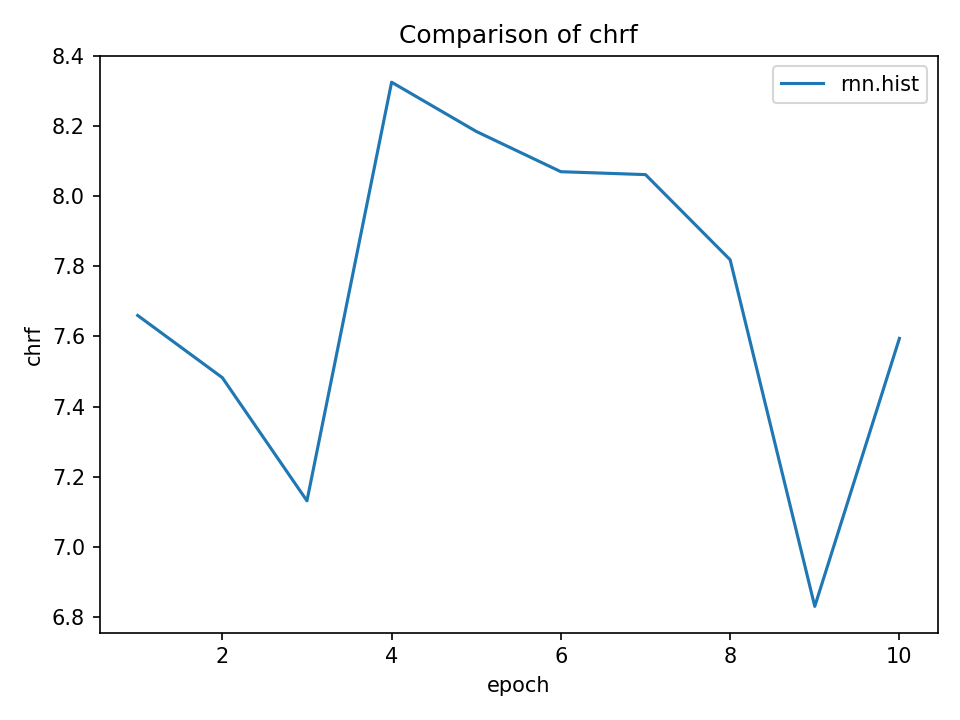

In [5]:
!python plot_history.py rnn.hist --metric chrf --save rnn_chrf.png
display(Image(filename="rnn_chrf.png"))

### 5.2.5 Translating with the `rnn_seq2seq.py` script

We can also use the script in translate mode to translate a file. Here are the options:

| Option | Default | Comment |
|---|---:|---|
| `--mode` | `translate` | Run the script in translation mode |
| `--load` | – | Model checkpoint to load (required) |
| `--src-test` | – | Source file to translate (batch mode) |
| `--tgt-test` | – | Reference translations (optional, for metrics) |
| `--output` | – | Output file for translations |
| `--batch-size` | 32 | Batch size for decoding |
| `--max-len` | 20 | Maximum generated sentence length |
| `--replace-unk` | false | Replace `<unk>` using attention alignment |
| `--show-src-unk` | false | Print source sentence with `<unk>` markers |
| `--lower` | false | Lowercase input text |
| `--subword-type` | `none` | Subwording (`none`, `bpe`, `unigram`) |
| `--src-sp-model` | – | Source SentencePiece model |
| `--tgt-sp-model` | – | Target SentencePiece model |
| `--eval-metrics` | false | Compute metrics if references are provided |
| `--seed` | 42 | Random seed |


To translate the `test.en` file we can use the following command, using the best model from the
baseline training.

In [6]:
!python rnn_seq2seq.py \
  --mode translate \
  --load rnn_baseline.best.pt \
  --src-test /kaggle/input/tatoeba-en-nl/test.en \
  --tgt-test /kaggle/input/tatoeba-en-nl/test.nl \
  --output test.rnn_baseline.nl \
  --eval-metrics


Setting random seed to 42
Subword mode: none (word-level).
Loaded checkpoint from rnn_baseline.best.pt (epoch 2)
Total trainable parameters: 5,094,981
Interactive translation mode. Type a sentence and press Enter (Ctrl+C to exit).
[info] Wrote hypotheses to test.rnn_baseline.nl
[metrics] BLEU=0.17  ChrF=7.39  TER=96.36


This writes an output file with the translations and also provides us with scores for the metrics
included in SacreBleu (Bleu, chrF, TER)

## 5.3 From Plain RNNs to Gated Recurrent Units and Long Short-Term Memory

The vanilla RNN encoder–decoder introduced in the previous section already demonstrates the
core idea of neural machine translation. However, it also exhibits a well-known weakness: it
struggles to remember information over longer sequences. This problem is commonly referred to
as the *vanishing gradient problem*.

In practice, this means that early words in a sentence may have little influence on later predictions, especially when sentences become longer. To address this limitation, researchers introduced \emph{gated recurrent architectures}. These architectures modify the basic RNN cell so that the network can decide what information to keep, update, or forget.

In this section, we introduce two such architectures: the
**Gated Recurrent Unit (GRU)** and the **Long Short-Term Memory (LSTM)**.
Both can be used as drop-in replacements for plain RNNs in our NMT system.


### 5.3.1 The Idea of Gating
The key innovation behind GRUs and LSTMs is the concept of gating. A gate is a parameterised
mechanism that regulates how information is propagated through a recurrent network over time.
In a plain RNN, the hidden state is updated at every time step using the same operation: the
new input is always combined with the previous hidden state. As sequences become longer, this
repeated mixing makes it difficult to preserve information originating from earlier positions in
the sentence.

Gated recurrent architectures modify this update process by introducing additional control signals.
These signals scale different components of the hidden state update, allowing the network to
retain, suppress, or overwrite information in a controlled manner.

Each gate produces a continuous value between 0 and 1, which acts as a multiplicative factor.
Values close to 0 strongly attenuate the corresponding information flow, while values close to 1
allow it to pass through largely unchanged. The parameters governing these gates are learned
during training, just like all other model parameters.

In the context of machine translation, gating improves the ability of recurrent models to maintain
relevant information—such as grammatical features or semantic content—across longer input
sequences, thereby reducing the tendency to lose or distort earlier context.

The figure below shows the different architectures between the different types of RNN cells

![Gated](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*zFrSLqF97oZO_o8yJmLIVQ.png)

Architecture of the Hidden Layer cells: comparing RNN, LSTM and GRU (from https://sirineamrane.medium.com/introduction-to-recurrent-neural-networks-classic-rnn-lstm-and-gru-ec76d84f286d)

### 5.3.2 Gated recurrent units (GRUs)
The Gated Recurrent Unit (GRU) was introduced by Cho et al. (2014) as an alternative to the
plain RNN that can better model long-distance dependencies

#### 5.3.2.1 Intuition
Instead of blindly updating its internal state at every time step, a GRU uses *gates* to control information flow:

* an **update gate** decides how much of the previous state should be carried forward;
* a **reset gate** decides how much past information should be ignored when computing new content.

Intuitively, a GRU can learn to:
* keep important information over many time steps (e.g.\ subject or tense),
* forget irrelevant details,
* update its memory only when needed.

This makes GRUs much more effective than plain RNNs for translation, while keeping the architecture relatively simple.

#### 5.3.2.2 GRUs in Our NMT System
In our training script, switching from a plain RNN to a GRU requires only a single option change,
changing `--rnn-type` from its default value `rnn` to `gru`. We also change the resulting model with
the `--save` option and the name of the `--history-json` file.

In [7]:
!python rnn_seq2seq.py --src-file /kaggle/input/tatoeba-en-nl/train.en \
--tgt-file /kaggle/input/tatoeba-en-nl/train.nl \
--src-val /kaggle/input/tatoeba-en-nl/dev.en \
--tgt-val /kaggle/input/tatoeba-en-nl/dev.nl \
--rnn-type gru \
--epochs 10 \
--save gru.pt \
--show-val-examples 5 \
--eval-metrics \
--lower \
--history-json gru.hist

Setting random seed to 42
Loaded 1000 validation sentence pairs.
Source vocab size: 15514
Target vocab size: 20997
[info] lower = True
Loaded 77381 training pairs. 76539 used after max_len=20 filtering. 
Total trainable parameters: 5,194,309
Epoch 01: train NLL=4.8374 (ppl=126.14)  val NLL=4.5956 (ppl=99.04)  BLEU=0.98  ChrF=11.53  TER=86.18

--- Example validation translations ---
[1] SRC: nobody reads about my country .
    REF: niemand leest over mijn land .
    HYP: was mijn mijn is . .

[2] SRC: i sleep in my car .
    REF: ik slaap in mijn auto .
    HYP: ben mijn in mijn .

[3] SRC: there 're clean sheets under the bed .
    REF: er liggen schone lakens onder het bed .
    HYP: zijn de de de van de . .

[4] SRC: i have a donkey .
    REF: ik heb een ezel .
    HYP: heb een een . .

[5] SRC: betty drives fast .
    REF: betty rijdt snel .
    HYP: heeft een . .

---------------------------------------
Epoch 02: train NLL=3.9201 (ppl=50.40)  val NLL=4.1802 (ppl=65.38)  BLEU=2.14  

All other aspects of the model remain unchanged. This allows us to directly measure the impact
of gating on translation quality.

During the training process, we can now already see some meaningful words in the example
validation translations.

#### 5.3.2.3 Monitoring the learning curves

Similar as before we can create the learning curve charts.

Saved plot to gru.png


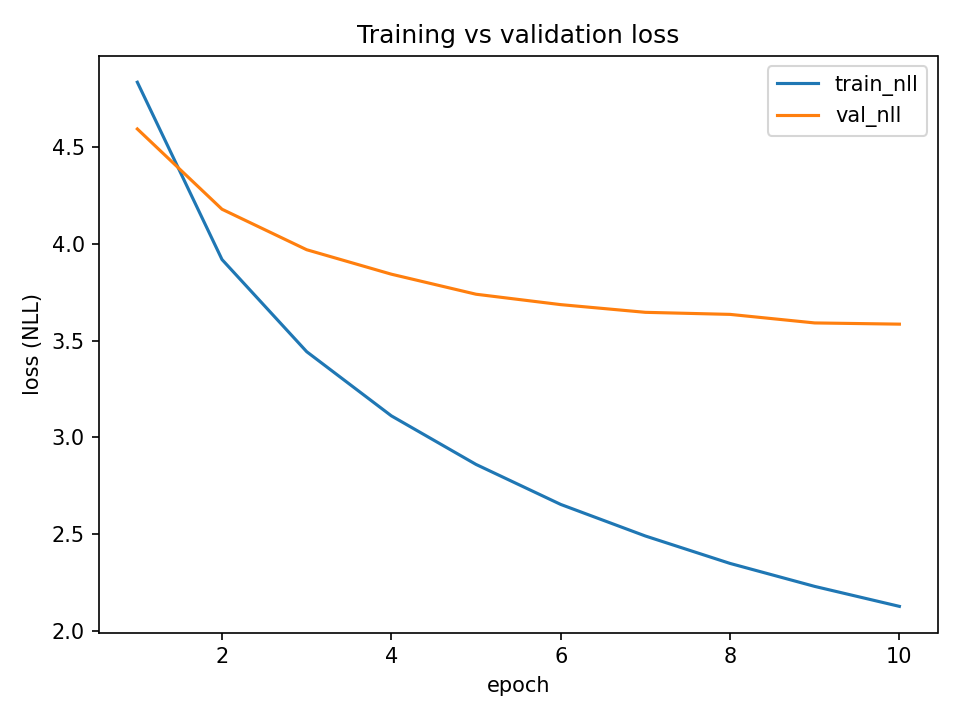

In [8]:
!python plot_train_val.py gru.hist --save gru.png
display(Image(filename="gru.png"))

The figure above shows that validation loss initially diminshes, but starts to converge after 6 epochs,
while learning for the training data continues. So the model learns during the first few epochs, but then starts to overfit.

Now we compare the loss and BLEU scores of the GRU models with the plain RNN
models. 

Saved plot to rnn_gru_nll.png


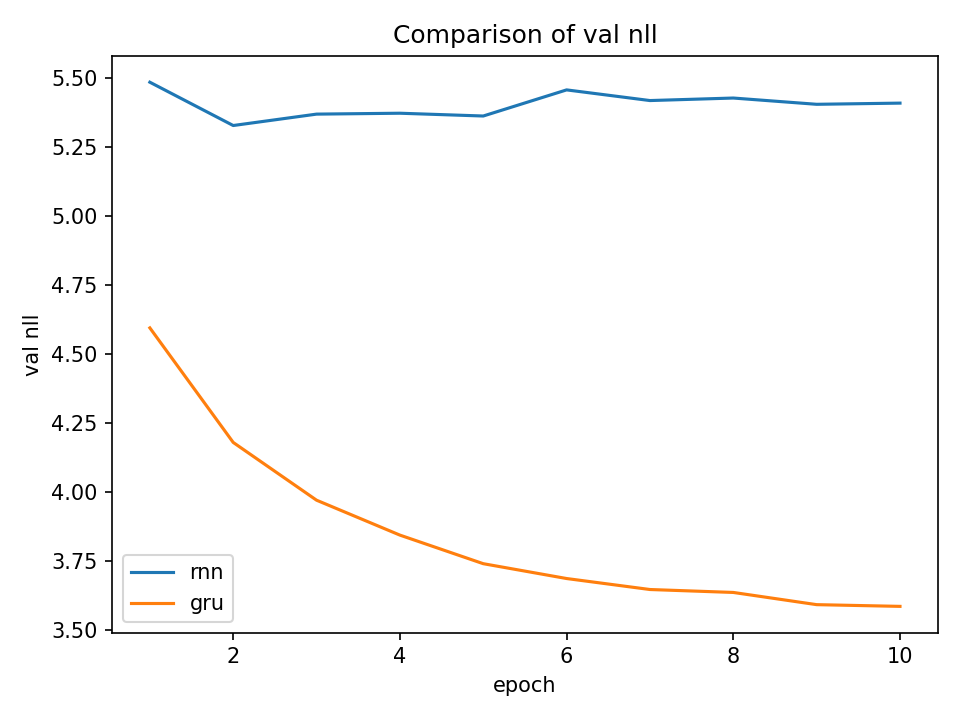

Saved plot to rnn_gru_bleu.png


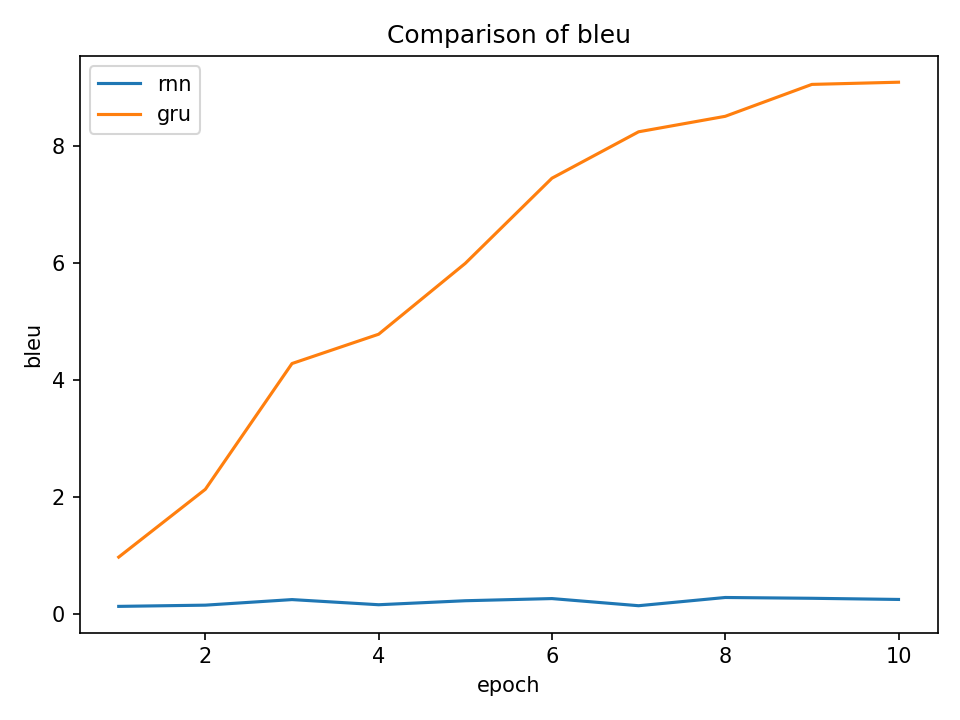

In [9]:
!python plot_history.py rnn.hist gru.hist \
--labels rnn gru \
--save rnn_gru_nll.png
display(Image(filename="rnn_gru_nll.png"))

!python plot_history.py rnn.hist gru.hist \
--labels rnn gru \
--metric bleu \
--save rnn_gru_bleu.png
display(Image(filename="rnn_gru_bleu.png"))

We can see that GRU scores substantially better, both for loss (lower is better) and for
BLEU (higher is better). While RNNs do show no learning on validation, GRU models at least
show some loss reduction and BLEU score improvement

### 5.3.3 Long Short-Term Memory (LSTM)
The Long Short-Term Memory (LSTM) architecture was introduced earlier by Hochreiter and
Schmidhuber (1997) and is one of the most influential recurrent models in neural network history.

#### 5.3.3.1 Intuition

An LSTM explicitly separates:
* a **cell state** (long-term memory),
* a **hidden state** (short-term working memory).

Three gates control how information flows through the cell:
* a **forget gate** decides what information to discard;
* an **input gate** decides what new information to store;
* an **output gate** decides what information to expose to the next layer.

This explicit memory design allows LSTMs to preserve information over very long
sequences, making them particularly robust for sequence-to-sequence tasks such
as translation.


#### 5.3.3.2 LSTMs in Our NMT System
Switching to an LSTM in our experiments is again straightforward

In [10]:
!python rnn_seq2seq.py --src-file /kaggle/input/tatoeba-en-nl/train.en \
--tgt-file /kaggle/input/tatoeba-en-nl/train.nl \
--src-val /kaggle/input/tatoeba-en-nl/dev.en \
--tgt-val /kaggle/input/tatoeba-en-nl/dev.nl \
--rnn-type lstm \
--epochs 10 \
--save lstm.pt \
--show-val-examples 5 \
--eval-metrics \
--lower \
--history-json lstm.hist

Setting random seed to 42
Loaded 1000 validation sentence pairs.
Source vocab size: 15514
Target vocab size: 20997
[info] lower = True
Loaded 77381 training pairs. 76539 used after max_len=20 filtering. 
Total trainable parameters: 5,243,973
Epoch 01: train NLL=5.0858 (ppl=161.72)  val NLL=4.9182 (ppl=136.76)  BLEU=0.22  ChrF=7.90  TER=90.38

--- Example validation translations ---
[1] SRC: nobody reads about my country .
    REF: niemand leest over mijn land .
    HYP: is in van . .

[2] SRC: i sleep in my car .
    REF: ik slaap in mijn auto .
    HYP: was in in . .

[3] SRC: there 're clean sheets under the bed .
    REF: er liggen schone lakens onder het bed .
    HYP: was de van de . .

[4] SRC: i have a donkey .
    REF: ik heb een ezel .
    HYP: is een . .

[5] SRC: betty drives fast .
    REF: betty rijdt snel .
    HYP: zijn . .

---------------------------------------
Epoch 02: train NLL=4.2096 (ppl=67.33)  val NLL=4.3741 (ppl=79.37)  BLEU=1.00  ChrF=11.91  TER=84.28

--- Ex

We can check the training versus validation loss history by generating the history chart

Saved plot to lstm.png


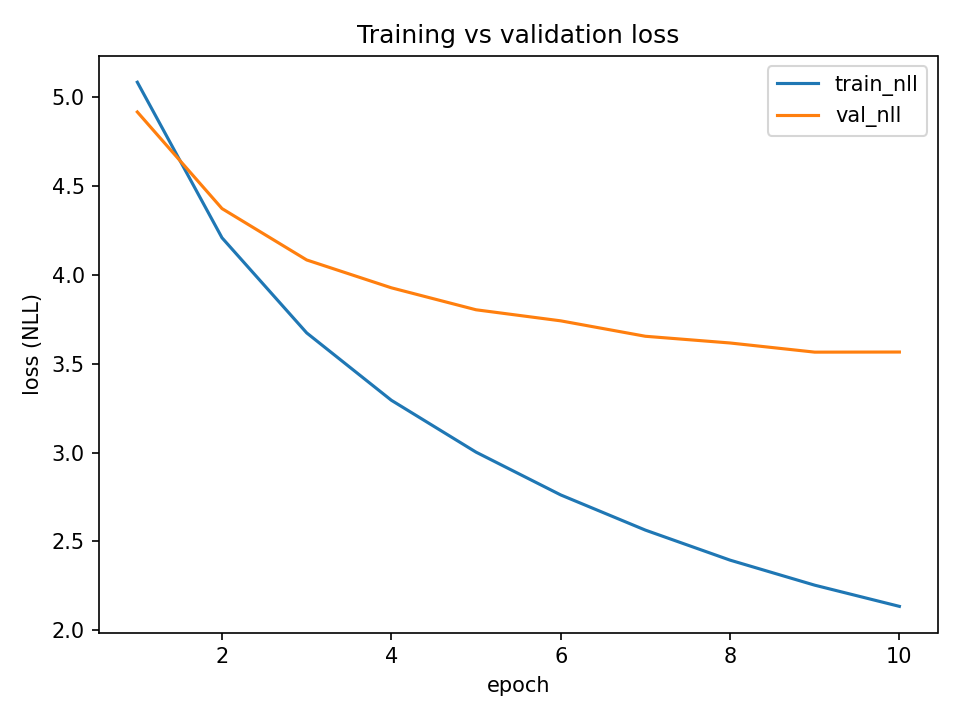

In [11]:
!python plot_train_val.py lstm.hist --save lstm.png
display(Image(filename="lstm.png"))

Training LSTMs in this case seems to be effective up to 4 epochs, after which the system converges
on the validation set.

We can now also compare the BLEU and loss scores for RNNs, GRUs and LSTMs under identical experimental conditions.

Saved plot to rnn_gru_lstm_nll.png


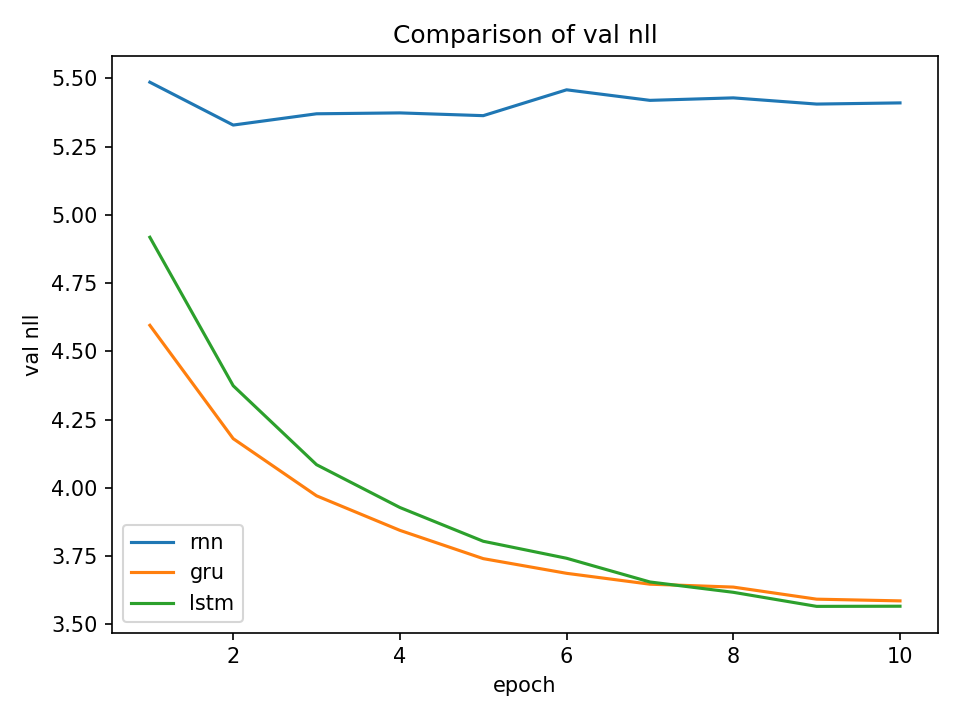

Saved plot to rnn_gru_lstm_bleu.png


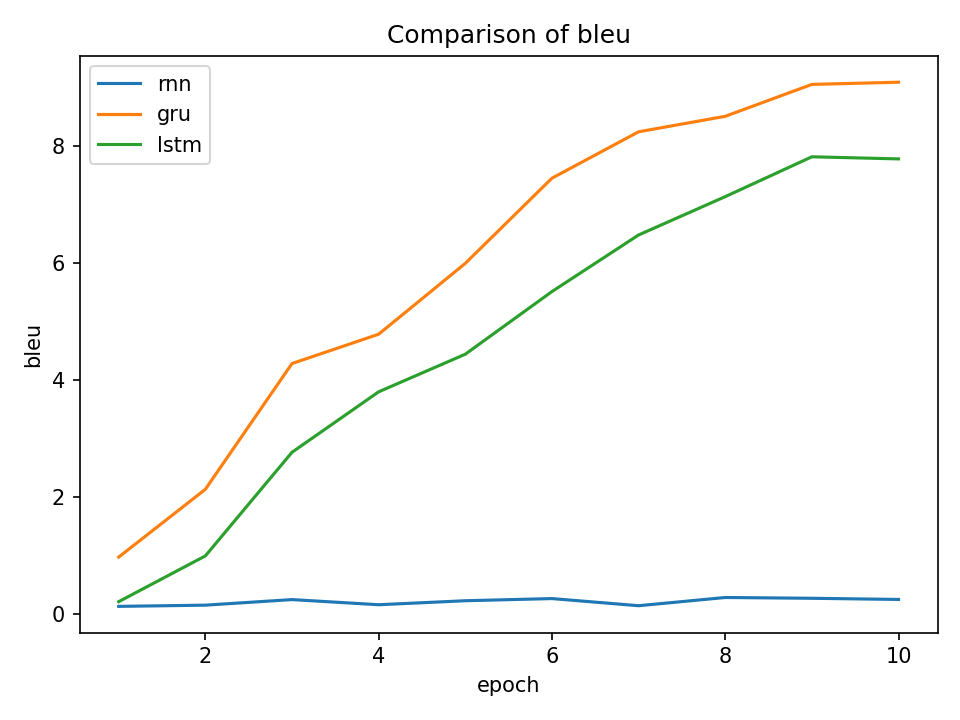

In [12]:
!python plot_history.py rnn.hist gru.hist lstm.hist \
--labels rnn gru lstm \
--save rnn_gru_lstm_nll.png
display(Image(filename="rnn_gru_lstm_nll.png"))

!python plot_history.py rnn.hist gru.hist lstm.hist \
--labels rnn gru lstm \
--metric bleu \
--save rnn_gru_lstm_bleu.png
display(Image(filename="rnn_gru_lstm_bleu.png"))

From these graphs we can conclude that vanilla RNNs function significantly worse than GRUs
and LSTMs. The difference between these latter two does not seem to be very large. This may
be due to the fact that Tatoeba sentences tend to be rather short, so the gain of using LSTMs is
limited

**GRU vs. LSTM in practice**. 

In many MT settings:
* GRUs train slightly faster and use fewer parameters;
* LSTMs can be more stable for very long sentences;
* differences in final BLEU scores are often modest.

For this reason, both architectures have been widely used in neural machine translation

## 5.4 Bidirectional Encoders
Bidirectional recurrent networks were originally introduced for general sequence modelling tasks
by Schuster and Paliwal (1997). The first neural machine translation systems based on encoder-decoder architectures (Cho et al., 2014; Sutskever et al., 2014) employed unidirectional encoders
that processed the source sentence from left to right. Shortly thereafter, bidirectional encoders were
adopted in neural machine translation to improve the quality of source sentence representations.

Early influential NMT models incorporating bidirectional encoders include the systems of Bah-
danau et al. (2015) and Luong et al. (2015), which demonstrated that processing the source
sentence in both directions leads to more informative encodings and improved translation quality.
As a result, bidirectionality became a standard component of recurrent neural machine translation
architectures.

So far, all encoder–decoder models we have considered process the source sentence from left to
right. At each time step, the encoder’s hidden state summarises the input seen so far, but has no
access to future words. This asymmetry turns out to be a limitation for many language pairs,
especially when important information appears late in the source sentence.

Bidirectional recurrent networks address this limitation by processing the source sentence in both
directions.

### 5.4.1 Motivation

Consider the following English example: `The book that I bought yesterday is expensive`.

When reading from left to right, the encoder does not encounter the main verb is until late in
the sentence. However, this verb is crucial for generating a correct Dutch translation, particularly
for word order and verb placement.

A unidirectional encoder must compress all earlier information without knowing what comes next.

A bidirectional encoder, by contrast, has access to both past and future context at every position

### 5.4.2 What Does Bidirectional Mean?

A bidirectional recurrent encoder consists of two separate RNNs:
* a **forward RNN** that reads the source sentence from left to right;
* a **backward RNN** that reads the source sentence from right to left.

For each position in the sentence, the hidden states from these two RNNs are combined (typically
by concatenation). As a result, the encoder representation at each position contains information
about:

* the words that precede the current position, and
* the words that follow it.

This makes the source representation more informative, without changing the decoder architecture.

![](https://github.com/VincentCCL/MTAT/blob/main/notebooks/brnn.png?raw=true)

Bidirectional Encoder: It consists of two recurrent neural networks, running right
to left and left to right. The encoder states are the combination of the two hidden states of the
recurrent neural networks. From Koehn (2020).

### 5.4.3 Bidirectionality in Encoder–Decoder NMT

In neural machine translation, bidirectionality is almost always applied only to the encoder :
* The **encoder** benefits from seeing the full source sentence in both directions.
* The **decoder** must remain left-to-right, because it generates the target sentence sequentially.

From an architectural point of view, nothing else changes: the decoder still starts from an initial
state derived from the encoder, and training still uses teacher forcing.

With a bidirectional encoder, the decoder is initialised with a state that combines the final forward
and backward encoder states, for instance, by concatenation. This state encodes information
from both directions of the source sentence

### 5.4.4 Using a Bidirectional Encoder in Our Experiments

In our training script, enabling a bidirectional encoder is straightforward: we just need to add
the option `--bidirectional`. Note that we continue using `--rnn-type lstm`.

In [13]:
!python rnn_seq2seq.py --src-file /kaggle/input/tatoeba-en-nl/train.en \
--tgt-file /kaggle/input/tatoeba-en-nl/train.nl \
--src-val /kaggle/input/tatoeba-en-nl/dev.en \
--tgt-val /kaggle/input/tatoeba-en-nl/dev.nl \
--rnn-type lstm \
--epochs 10 \
--save blstm.pt \
--show-val-examples 5 \
--eval-metrics \
--lower \
--bidirectional \
--history-json blstm.hist

Setting random seed to 42
Loaded 1000 validation sentence pairs.
Source vocab size: 15514
Target vocab size: 20997
[info] lower = True
Loaded 77381 training pairs. 76539 used after max_len=20 filtering. 
Total trainable parameters: 8,261,317
Epoch 01: train NLL=4.6223 (ppl=101.73)  val NLL=4.3095 (ppl=74.40)  BLEU=0.91  ChrF=12.73  TER=84.79

--- Example validation translations ---
[1] SRC: nobody reads about my country .
    REF: niemand leest over mijn land .
    HYP: heeft mijn mijn mijn . .

[2] SRC: i sleep in my car .
    REF: ik slaap in mijn auto .
    HYP: woon in in . .

[3] SRC: there 're clean sheets under the bed .
    REF: er liggen schone lakens onder het bed .
    HYP: zijn de de de de . .

[4] SRC: i have a donkey .
    REF: ik heb een ezel .
    HYP: heb een . .

[5] SRC: betty drives fast .
    REF: betty rijdt snel .
    HYP: alsjeblieft . .

---------------------------------------
Epoch 02: train NLL=3.5883 (ppl=36.17)  val NLL=3.8554 (ppl=47.25)  BLEU=3.28  ChrF=1

Saved plot to blstm.png


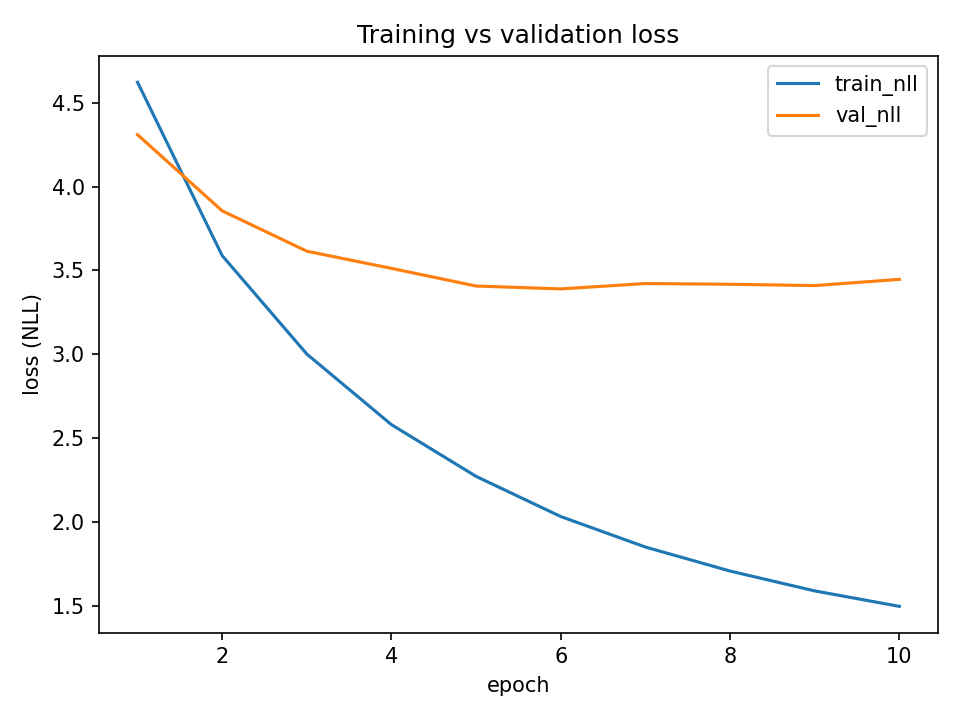

Saved plot to rnn_gru_lstm_blstm_nll.png


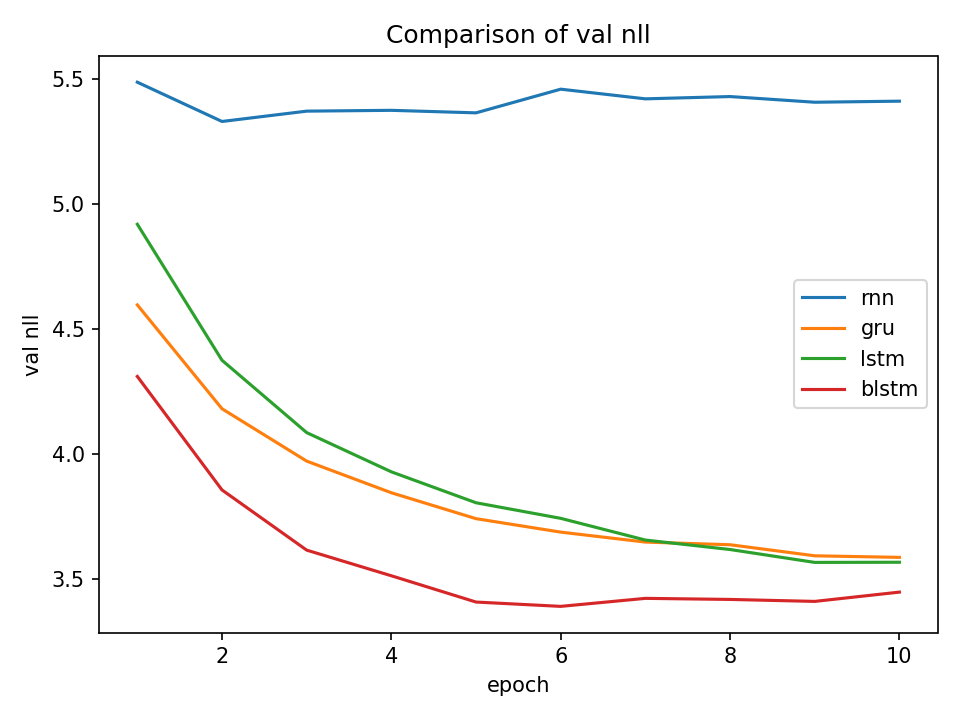

Saved plot to rnn_gru_lstm_blstm_bleu.png


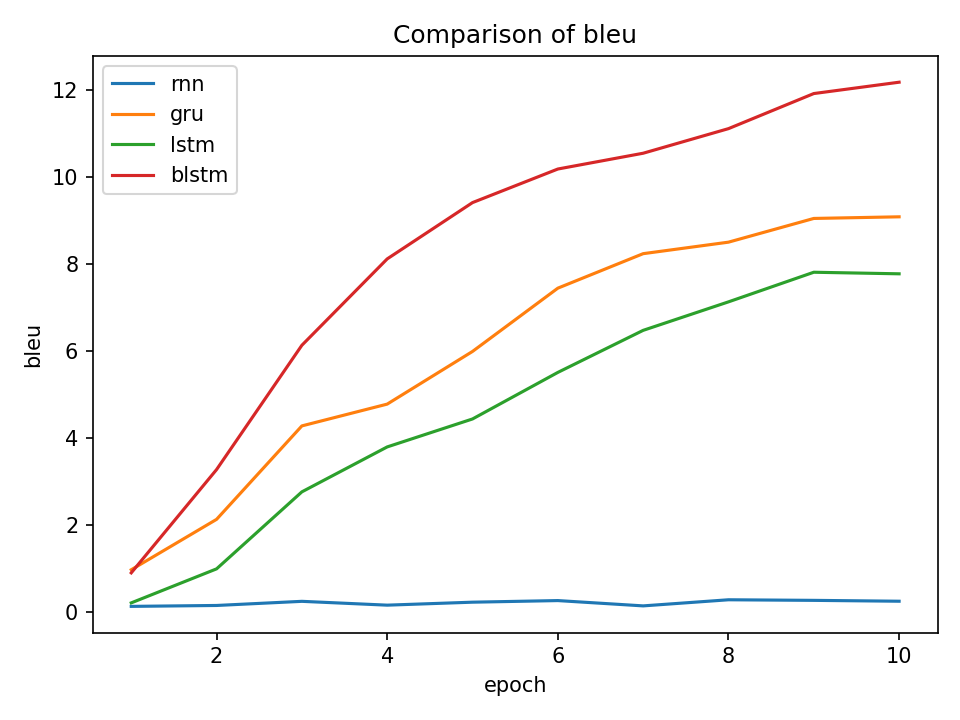

In [14]:
!python plot_train_val.py blstm.hist \
--save blstm.png
display(Image(filename="blstm.png"))

!python plot_history.py rnn.hist gru.hist lstm.hist blstm.hist \
--labels rnn gru lstm blstm \
--save rnn_gru_lstm_blstm_nll.png
display(Image(filename="rnn_gru_lstm_blstm_nll.png"))

!python plot_history.py rnn.hist gru.hist lstm.hist blstm.hist \
--labels rnn gru lstm blstm \
--metric bleu \
--save rnn_gru_lstm_blstm_bleu.png
display(Image(filename="rnn_gru_lstm_blstm_bleu.png"))

As we can see from the first figure, the validation loss improves over the few first epochs and then
converges, while the training loss further improves, leading to overfitting.

The later figures show us the improvements of adding bidirectionality over the previous approaches.
* We see first that the validation loss is substantially lower for the bidirectional model,
* a similar observation can be made about the BLEU score, where we see a
substantially better BLEU score for the bidirectional model compared to the prevous approaches.

### 5.4.5 Limitations
While bidirectional encoders improve source representations, they do not remove the fundamental
bottleneck of encoder–decoder models: the decoder still relies on a fixed-size summary of the
source sentence. This limitation motivates the introduction of attention mechanisms, which we
discuss in the next sectionAttention

## 5.5 Cross-Lingual Attention

### 5.5.1 Introduction
Cross-lingual attention was first introduced into neural machine translation by Bahdanau et al.
(2015). Shortly thereafter, alternative formulations were proposed, notably by Luong et al. (2015),
which differ in how the relevance between decoder states and encoder states is computed. Despite
these variations, the core idea remains the same: target words are generated by dynamically
attending to the source sentence.

Early encoder–decoder models rely on a single fixed-size vector to summarise the entire source
sentence. Even when using gated recurrent units or bidirectional encoders, this design introduces a
fundamental limitation: all source information must be compressed into one representation before
decoding begins. As sentences become longer or structurally more complex, this information
bottleneck increasingly degrades translation quality.

Cross-lingual attention was introduced to address this limitation by allowing the decoder to
directly access different parts of the source sentence during translation. This idea is motivated by
human translation behaviour: when producing a target word, translators typically focus on a
specific source word or phrase rather than on a global sentence summary. In early encoder–decoder
NMT systems, such selective focus was impossible—once encoding was complete, the decoder
could not revisit the source sentence.

With attention, the encoder no longer produces a single vector but a sequence of hidden states,
one for each source position, forming a distributed representation of the input. At each decoding
step, the decoder computes a set of weights over these encoder states, indicating how strongly
each source position contributes to the prediction of the current target word. The resulting
weighted combination of encoder states, known as the *context vector*, enables the decoder to
condition each target word on the most relevant parts of the source sentence.

### 5.5.2 Attention as Cross-Lingual Alignment
Cross-lingual attention can be interpreted as a form of soft alignment between source and target
tokens, as shown in the figure below.

For each target position, the attention mechanism produces a probability distribution over source
positions:
* high weights indicate strong relevance,
* low weights indicate weak or no relevance.

Unlike traditional word alignment models in statistical MT, attention does not commit to a single
alignment point. Instead, it distributes probability mass across multiple source positions, allowing
for many-to-one and one-to-many correspondences. This is particularly important for languages with different word orders or rich morphology.

<img src="https://github.com/VincentCCL/MTAT/blob/main/notebooks/cross_attention.png?raw=true" width="300">

The encoder–decoder models introduced so far rely on a single fixed-size vector to summarise
the entire source sentence. Even with gated recurrent units and bidirectional encoders, this
design imposes a fundamental limitation: all source information must be compressed into one
representation before decoding begins. As sentences become longer or structurally more complex,
this bottleneck degrades translation quality.

Cross-lingual attention was introduced to address this limitation by allowing the decoder to
directly access different parts of the source sentence during translation.

### 5.5.3 How Attention Fits into the Encoder–Decoder Architecture

With the introduction of attention, the role of the encoder changes subtly. Rather than producing
a single summary vector for the entire source sentence, the encoder outputs a sequence of
representations, one for each source position. The decoder therefore no longer relies exclusively
on its initial hidden state to encode all source information. Instead, relevant source information
is retrieved dynamically at each decoding step through the attention mechanism, allowing the
decoder to adapt its focus as the translation unfolds.

The decoder’s hidden state and the context vector are combined to predict the next target word.
Importantly, the decoder remains a left-to-right conditional language model; attention augments
it with source-side context rather than replacing it.

### 5.5.4 Practical Consequences for Translation

Introducing cross-lingual attention leads to several practical improvements in neural machine
translation. By allowing the decoder to access source information directly at each time step,
attention enables more robust handling of long sentences and reduces the risk of omitting relevant
source content. It also contributes to improved word order and overall adequacy by grounding
each target word in the most relevant parts of the source sentence. In addition, the attention
weights provide interpretable alignment patterns that can be visualised, offering valuable insight
into the model’s translation behaviour.

These gains are often larger than those obtained from increasing model depth or hidden size,
making attention one of the most influential innovations in recurrent neural machine translation

### 5.5.5 Cross-lingual Attention in practice

In the script that we use we can activate the attention mechanism of Luong et al. (2015) by using
the option `--attention luong`. We keep using a bidirectional LSTM model.

In [15]:
!python rnn_seq2seq.py --src-file /kaggle/input/tatoeba-en-nl/train.en \
--tgt-file /kaggle/input/tatoeba-en-nl/train.nl \
--src-val /kaggle/input/tatoeba-en-nl/dev.en \
--tgt-val /kaggle/input/tatoeba-en-nl/dev.nl \
--rnn-type lstm \
--epochs 10 \
--save blstm_att.pt \
--show-val-examples 5 \
--eval-metrics \
--lower \
--bidirectional \
--history-json blstm_att.hist \
--attention luong

Setting random seed to 42
Loaded 1000 validation sentence pairs.
Source vocab size: 15514
Target vocab size: 20997
[info] lower = True
Loaded 77381 training pairs. 76539 used after max_len=20 filtering. 
Total trainable parameters: 8,458,181
Epoch 01: train NLL=4.1903 (ppl=66.04)  val NLL=3.6508 (ppl=38.51)  BLEU=7.69  ChrF=24.94  TER=74.82

--- Example validation translations ---
[1] SRC: nobody reads about my country .
    REF: niemand leest over mijn land .
    HYP: is er mijn land . .

[2] SRC: i sleep in my car .
    REF: ik slaap in mijn auto .
    HYP: ben in auto auto .

[3] SRC: there 're clean sheets under the bed .
    REF: er liggen schone lakens onder het bed .
    HYP: zijn van van onder de bed .

[4] SRC: i have a donkey .
    REF: ik heb een ezel .
    HYP: heb een . .

[5] SRC: betty drives fast .
    REF: betty rijdt snel .
    HYP: geen snel .

---------------------------------------
Epoch 02: train NLL=2.7909 (ppl=16.30)  val NLL=3.1726 (ppl=23.87)  BLEU=13.05  ChrF

Again, we generate the learning curves.

Saved plot to blstm_att.png


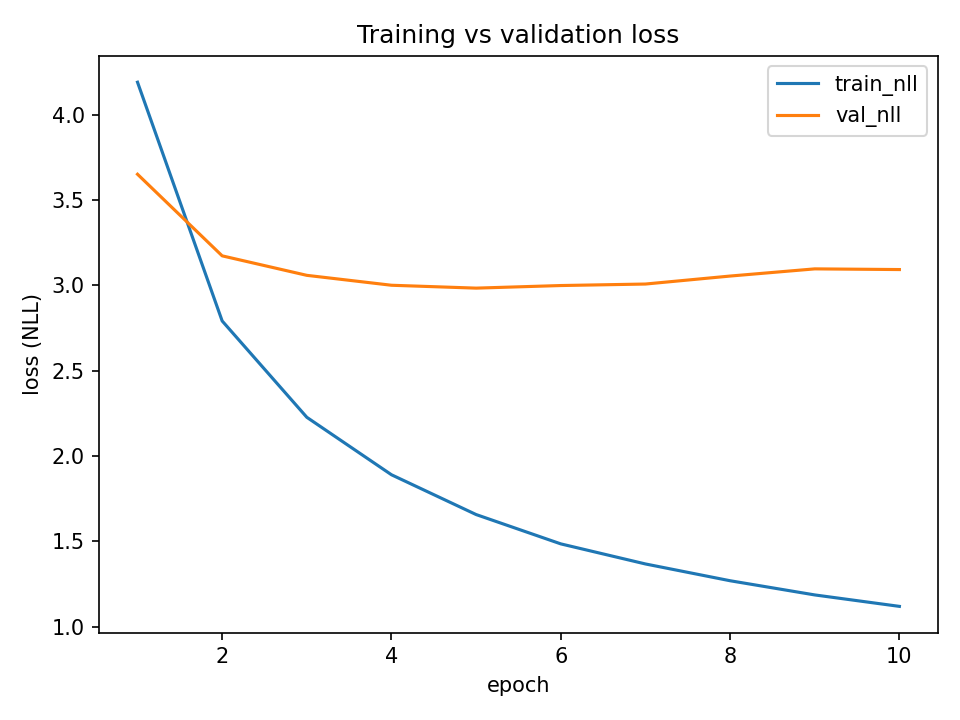

Saved plot to rnn_gru_lstm_blstm_att_nll.png


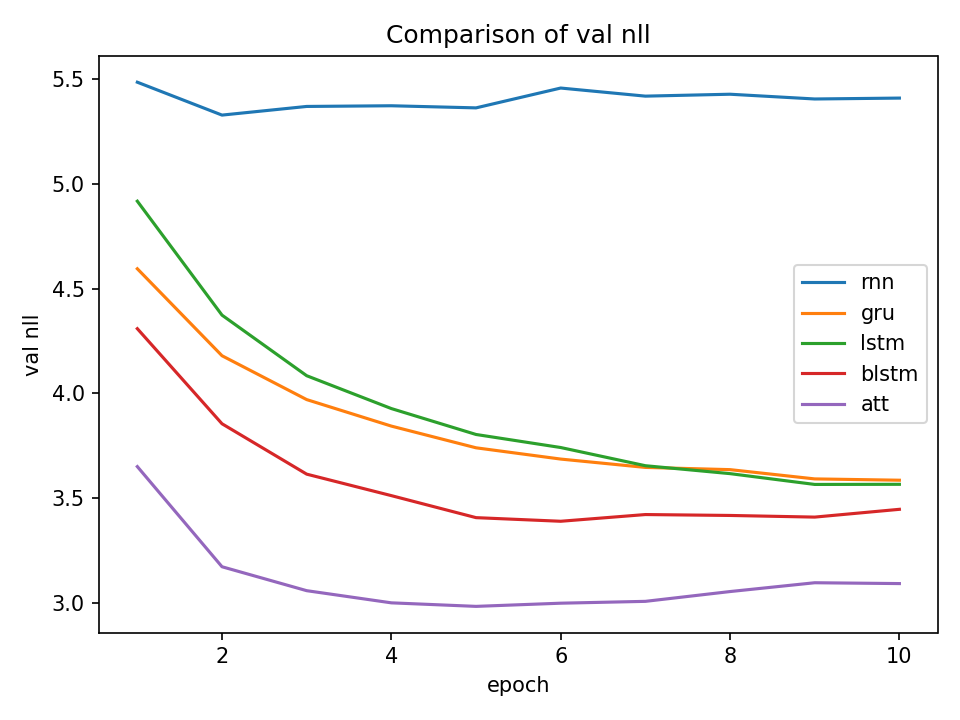

Saved plot to rnn_gru_lstm_blstm_att_bleu.png


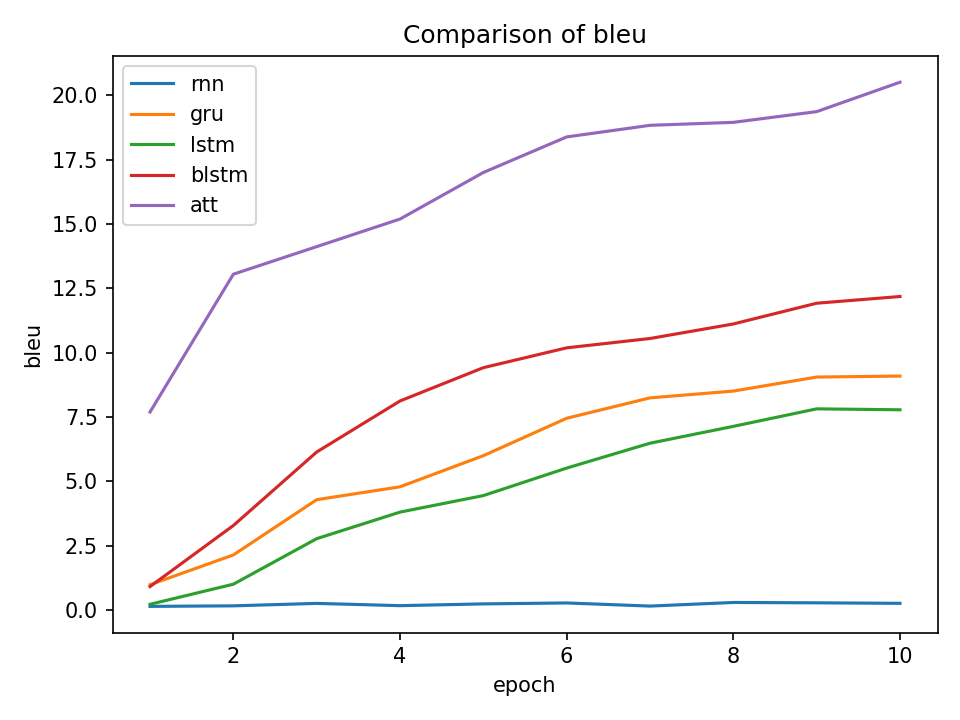

Saved plot to rnn_gru_lstm_blstm_att_chrf.png


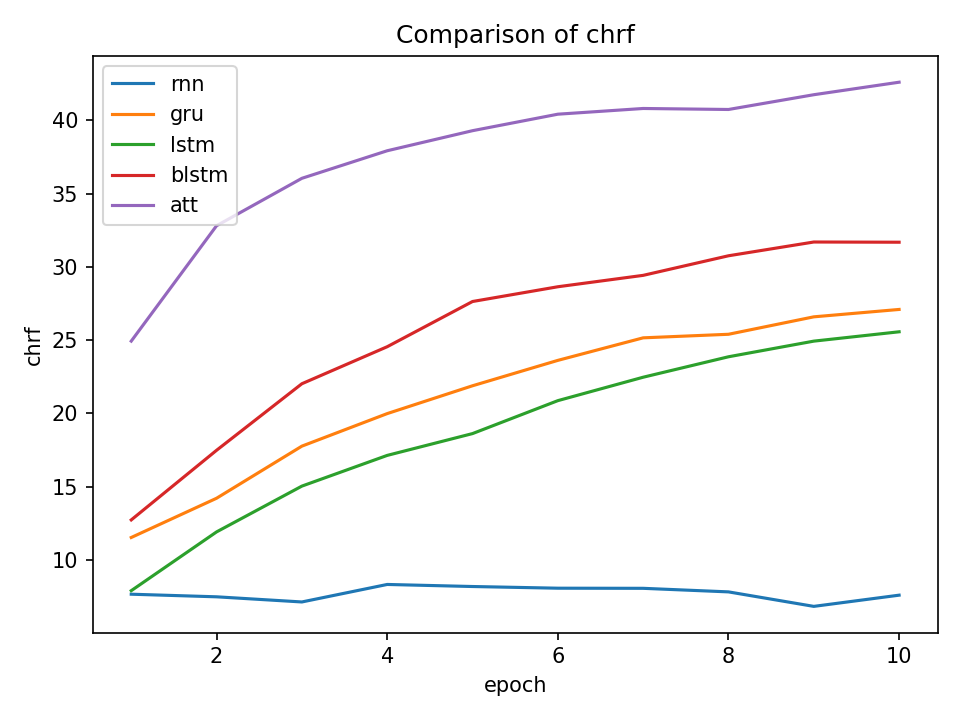

In [16]:
!python plot_train_val.py blstm_att.hist --save blstm_att.png
display(Image(filename="blstm_att.png"))

!python plot_history.py rnn.hist gru.hist lstm.hist blstm.hist blstm_att.hist \
--labels rnn gru lstm blstm att \
--save rnn_gru_lstm_blstm_att_nll.png
display(Image(filename="rnn_gru_lstm_blstm_att_nll.png"))

!python plot_history.py rnn.hist gru.hist lstm.hist blstm.hist blstm_att.hist \
--labels rnn gru lstm blstm att \
--metric bleu \
--save rnn_gru_lstm_blstm_att_bleu.png
display(Image(filename="rnn_gru_lstm_blstm_att_bleu.png"))

!python plot_history.py rnn.hist gru.hist lstm.hist blstm.hist blstm_att.hist \
--labels rnn gru lstm blstm att \
--metric chrf \
--save rnn_gru_lstm_blstm_att_chrf.png
display(Image(filename="rnn_gru_lstm_blstm_att_chrf.png"))

Similar as before, the figures shows overfitting. Initially we see improvement for both training
and validation loss, but already after two epochs validation loss seems to more or less converge.

Compared to the previous approaches, the figures show substantial further improvement that can be attributed to the attention mechanism, given that all other factors stay the same. This holds both for validation loss score,  as for BLEU scores. 

### 5.5.6 Relation to Earlier Approaches

Attention-based NMT systems reintroduce an explicit notion of alignment into neural translation models. In this sense, attention can be seen as a neural counterpart to alignment models used in statistical machine translation, but learned jointly with the translation model and optimised end-to-end.

This connection highlights how neural MT integrates ideas from earlier MT paradigms while overcoming many of their limitations.